In [3]:
import numpy as np
import tensorflow as tf

from tensorflow import keras
import keras.backend as K

import matplotlib.pyplot as plt

from tqdm import tqdm_notebook as tqdm

Using TensorFlow backend.


In [4]:
!ls -l trained_model/

合計 105972
-rw-rw-r-- 1 uchiumi uchiumi  7264736  6月 10 11:56 trained_cnn_v0.h5
-rw-rw-r-- 1 uchiumi uchiumi  4965880  6月  9 23:35 trained_vae.h5
-rw-rw-r-- 1 uchiumi uchiumi 23147968  6月 11 02:36 vae_stl10_epoch100.h5
-rw-rw-r-- 1 uchiumi uchiumi 73127096  6月 11 14:02 vgg16_stl10_v0.h5


In [5]:
with keras.utils.CustomObjectScope({'GlorotUniform': keras.initializers.glorot_uniform()}):
    model = keras.models.load_model('trained_model/vae_stl10_epoch100.h5', compile=False)
    model.summary()

Instructions for updating:
Colocations handled automatically by placer.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 96, 96, 3)         0         
_________________________________________________________________
conv2d (Conv2D)              (None, 96, 96, 32)        1568      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 48, 48, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 48, 48, 64)        32832     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 24, 24, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 24, 24, 128)       131200    
_________________________________________________________________
max_

In [6]:
from stl10_utils import read_all_images

x_train = read_all_images(path_to_data="./dataset/STL10/data/stl10_binary/train_X.bin")
x_train = x_train.astype('float32') / 255.
# x_train: (5000, 96, 96, 3)

sys.version_info(major=3, minor=6, micro=9, releaselevel='final', serial=0)


# Eval

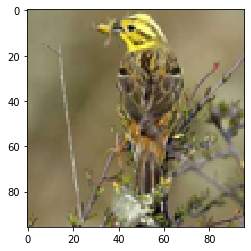

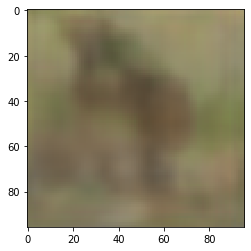

In [5]:
idx=0
plt.imshow(x_train[idx].reshape(96,96,3))
plt.show()

x_hat = model.predict(x_train[idx].reshape(1, 96, 96, 3))
plt.imshow(x_hat.reshape(96,96,3))
plt.show()

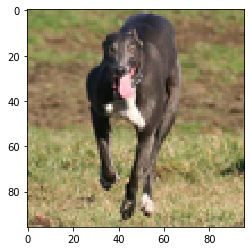

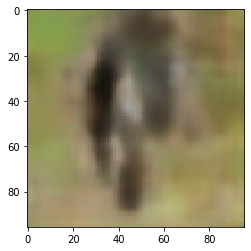

In [6]:
idx=1
plt.imshow(x_train[idx].reshape(96,96,3))
plt.show()

x_hat = model.predict(x_train[idx].reshape(1, 96, 96, 3))
plt.imshow(x_hat.reshape(96,96,3))
plt.show()

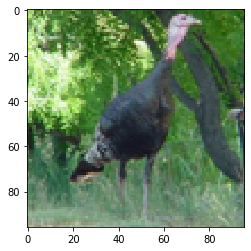

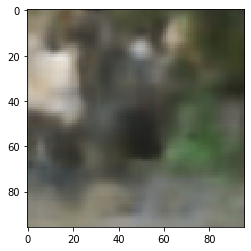

In [7]:
idx=2 
plt.imshow(x_train[idx].reshape(96,96,3))
plt.show()

x_hat = model.predict(x_train[idx].reshape(1, 96, 96, 3))
plt.imshow(x_hat.reshape(96,96,3))
plt.show()

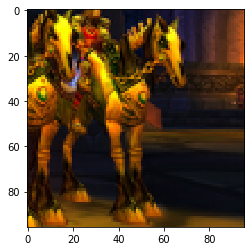

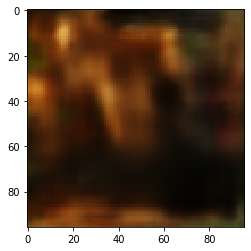

In [8]:
idx=3
plt.imshow(x_train[idx].reshape(96,96,3))
plt.show()

x_hat = model.predict(x_train[idx].reshape(1, 96, 96, 3))
plt.imshow(x_hat.reshape(96,96,3))
plt.show()

# Experiments

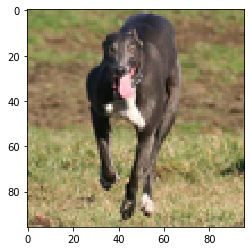

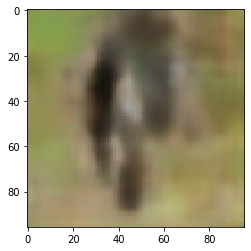

In [9]:
idx = 1
plt.imshow(x_train[idx].reshape(96,96,3))
plt.show()

x_hat = model.predict(x_train[idx].reshape(1, 96, 96, 3))
plt.imshow(x_hat.reshape(96,96,3))
plt.show()

In [13]:
idx = 1

x_true = x_train[idx].reshape(1, 96, 96, 3)
x_pred = model.output

init = tf.global_variables_initializer()
loss = tf.keras.losses.binary_crossentropy(x_true, x_pred)
get_grad = K.gradients(loss, model.get_layer("max_pooling2d_5").output)

sess = K.get_session()
sess.run(init)
gradient = sess.run(get_grad[0], feed_dict={model.input: x_true})

gradient = np.squeeze(gradient)
gradient.shape

(128,)

In [15]:
hessian_matrix = np.outer(gradient, gradient)

In [16]:
print("gradient : ", gradient.shape)
print("hessian_matrix : ", hessian_matrix.shape)

gradient :  (128,)
hessian_matrix :  (128, 128)


(128, 128)


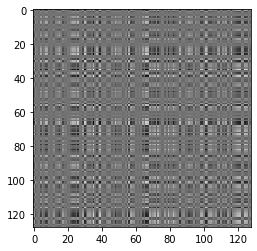

In [18]:
print(hessian_matrix.shape)

plt.imshow(hessian_matrix, "gray")
plt.show()

In [19]:
%%time

eig_values, eig_vectors = np.linalg.eigh(hessian_matrix)

eig_values = eig_values.astype(np.float32)
eig_vectors = eig_vectors.astype(np.float32)

for i in tqdm(range(len(eig_vectors))):
    eig_vectors[i] = eig_vectors[i] / np.linalg.norm(eig_vectors[i], ord=2)
    
max_eig_vector = eig_vectors[np.argmax(eig_values)]
max_eig_vector.shape

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  import sys



CPU times: user 84 ms, sys: 164 ms, total: 248 ms
Wall time: 46.9 ms


In [10]:
# z = model.get_layer("conv2d_6").inputs
# z = model.get_layer("max_pooling2d_5").output

z = tf.keras.layers.Input(shape=(128,))
decode = model.output
decoder = tf.keras.models.Model(inputs=z, outputs=decode)

ValueError: Graph disconnected: cannot obtain value for tensor Tensor("input_1:0", shape=(?, 96, 96, 3), dtype=float32) at layer "input_1". The following previous layers were accessed without issue: []

In [ ]:
from keras.models import Model


Original


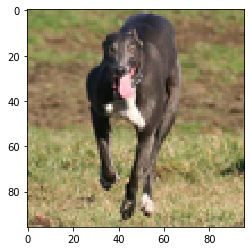

Decoded


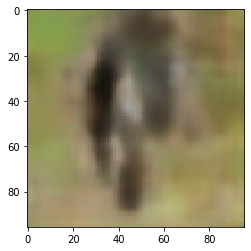

ValueError: cannot reshape array of size 128 into shape (96,96)

In [20]:
# Original

print("Original")

plt.imshow(x_true.reshape(96,96,3))
plt.show()

print("Decoded")

x_hat = model.predict(x_true.reshape(1, 96, 96, 3))
plt.imshow(x_hat.reshape(96,96,3))
plt.show()

# maximize FisherInformation

print("Input to maximize FI", max_eig_vector.reshape(96, 96).shape)

max_fim = max_eig_vector.reshape(96, 96)
max_fim = (max_fim - max_fim.min()) / (max_fim.max() - max_fim.min())
plt.imshow(np.where(max_fim < 0.94, 0, max_fim), "gray")
plt.show()

max_fim = max_eig_vector.reshape(96, 96)
max_fim = (max_fim - max_fim.min()) / (max_fim.max() - max_fim.min())
plt.imshow(np.where(max_fim < 0.75, 0, max_fim), "gray")
plt.show()

plt.imshow(max_eig_vector.reshape(96, 96) ,"gray")
plt.show()

In [ ]:
def zscore_gray_image(img):
    img_norm = (img - np.min(img)) / (np.max(img) - np.min(img))
    return img_norm


def zscore_color_image(img):
    img_a = img[:, :, 0]
    img_b = img[:, :, 1]
    img_c = img[:, :, 2]  # Extracting single channels from 3 channel image
    # The above code could also be replaced with cv2.split(img) << which will return 3 numpy arrays (using opencv)

    # normalizing per channel data:
    img_a = (img_a - np.min(img_a)) / (np.max(img_a) - np.min(img_a))
    img_b = (img_b - np.min(img_b)) / (np.max(img_b) - np.min(img_b))
    img_c = (img_c - np.min(img_c)) / (np.max(img_c) - np.min(img_c))

    # putting the 3 channels back together:
    img_norm = numpy.empty(img.shape, dtype=numpy.float32)
    img_norm[:, :, 0] = img_a
    img_norm[:, :, 1] = img_b
    img_norm[:, :, 2] = img_c

    return img_norm